# Librerias

In [ ]:
import numpy as np
import random
from pymoo.core.problem import Problem
from pymoo.problems import get_problem
from pymoo.visualization.util import plot
from pymoo.visualization.scatter import Scatter
from pymoo.indicators.hv import Hypervolume

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize

# Algoritmo propuesto

# Métricas

In [ ]:
def calculate_metrics(front, ref_point):
    # Hiperárea o hipervolumen
    hv = Hypervolume(ref_point).do(front)

    # Dispersión de Zitzler (SPR)
    spr = np.linalg.norm(np.max(front, axis=0) - np.min(front, axis=0))

    # Espaciado de Schott (SPA)
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)
    spa = np.mean(np.min(d + np.eye(len(d)) * np.inf, axis=1))

    return hv, spr, spa

# Funciones

## ZDT3

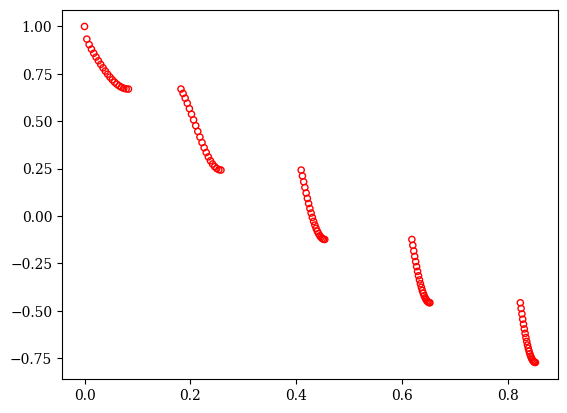

In [16]:
problem = get_problem("zdt3")
plot(problem.pareto_front(), no_fill=True)

## ZDT1

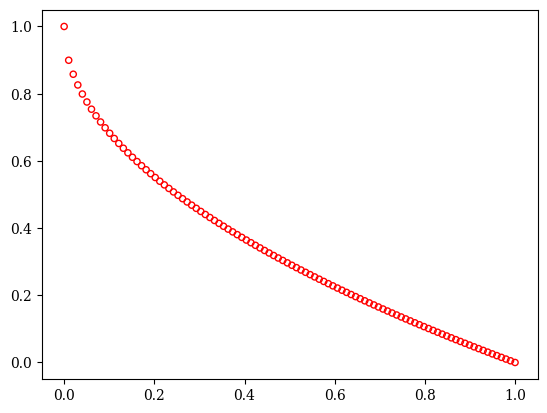

In [17]:
problem = get_problem("zdt1")
plot(problem.pareto_front(), no_fill=True)

## MW7

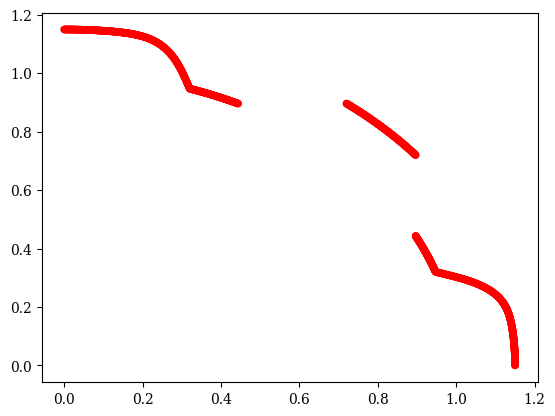

In [18]:
problem = get_problem("mw7")
plot(problem.pareto_front(), no_fill=True)

## MW14

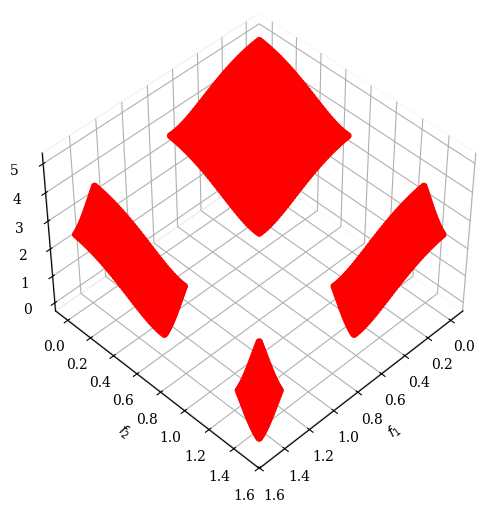

In [19]:
problem = get_problem("mw14").pareto_front()
Scatter(angle=(45,45)).add(problem, color="red").show()

### Problema

In [20]:
problem = get_problem("mw14", n_var = 30)
print(problem.n_var)
print(problem.n_obj)
print(problem.xl)
print(problem.xu)

30
3
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5
 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5 1.5]


In [21]:
algorithm = NSGA2(pop_size=100)
res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               verbose=False)

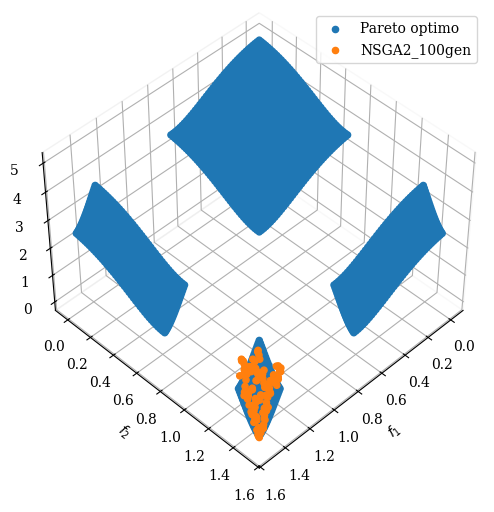

In [22]:
scatter = Scatter()
scatter.add(problem.pareto_front(), label="Pareto optimo")
scatter.add(res.F, label="NSGA2_100gen")
scatter.legend=True
scatter.show()

## TSPMO

Comprobación del funcionamiento del algoritmo NSGA2 para el TSPMO

In [23]:
class TSPProblem(Problem):
    def __init__(self, n_cities, seed=50):
        # Define the number of variables (cities) and objectives (time and distance)
        super().__init__(n_var=n_cities, n_obj=2, n_constr=0, xl=0, xu=1)
        
        # Initialize the random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
        
        # Generate random distances and times between cities
        self.distances = np.random.uniform(0, 100, size=(n_cities, n_cities))
        self.distances = (self.distances + self.distances.T) / 2
        self.times = np.random.uniform(0, 300, size=(n_cities, n_cities))
        random.seed(None)
        
        # Ensure the diagonal is zero (distance/time from a city to itself is zero)
        np.fill_diagonal(self.distances, 0)
        np.fill_diagonal(self.times, 0)

    def _evaluate(self, x, out, *args, **kwargs):
        # Calculate the total distance and time for each solution in x
        distances = []
        times = []
        
        for route in x:
            perm = np.argsort(route)
            total_distance = 0
            total_time = 0
            
            for i in range(len(perm) - 1):
                total_distance += self.distances[perm[i], perm[i+1]]
                total_time += self.times[perm[i], perm[i+1]]
            
            # Add distance and time from last city back to the first city
            total_distance += self.distances[perm[-1], perm[0]]
            total_time += self.times[perm[-1], perm[0]]
            
            distances.append(total_distance)
            times.append(total_time)
        
        out["F"] = np.column_stack([distances, times])

In [24]:
problem = TSPProblem(100)
print(np.shape(problem.distances))
print(np.shape(problem.times))

(100, 100)
(100, 100)


In [25]:
algorithm = NSGA2(pop_size=100)
algorithm2 = NSGA2(pop_size=50)
res = minimize(problem,
               algorithm,
               ('n_gen', 100),
               verbose=False)
res2 = minimize(problem,
               algorithm2,
               ('n_gen', 200),
               verbose=False)

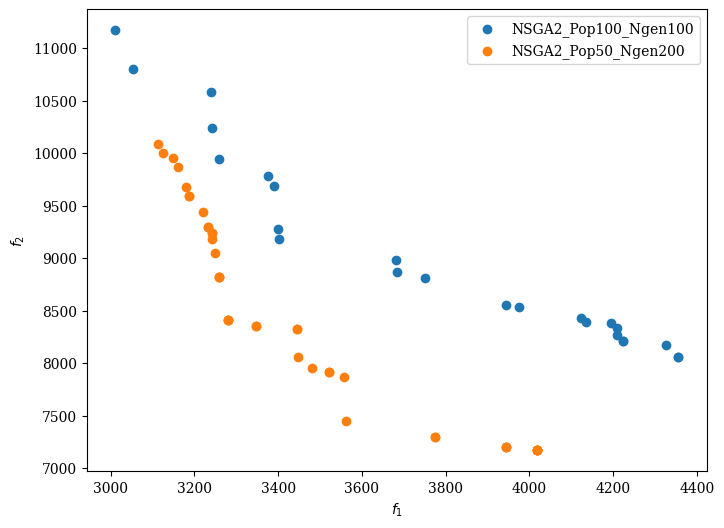

In [26]:
scatter = Scatter()
scatter.add(res.F, label="NSGA2_Pop100_Ngen100")
scatter.add(res2.F, label="NSGA2_Pop50_Ngen200")
scatter.legend=True
scatter.show()

Comprobación del funcionamiento del algoritmo NSGA2 para las funciones continuas